In this notebook we will see how using PCA to project our data onto some Principle Components, and consequently reducing the size of our feature matrix, affects the time taken to fit the model and it's accuracy.

Here we use a Logistic Regression Model to fit over the [MNIST dataset of handwritten digits.](http://yann.lecun.com/exdb/mnist/)

#### Libraries

In [1]:
import os
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#### Load Data

In [2]:
# this may take a while
data = fetch_openml('mnist_784', data_home=os.path.join('data', 'MNIST'))

In [3]:
# extract feature and target matrices
X = data.data.to_numpy()
y = data.target.to_numpy()

n_initial = X.shape[1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (70000, 784)
y: (70000,)


#### Useful Functions

In [4]:
# display an example with 784 features as image
def display_image(X, idx):
    plt.imshow(X[idx, :].reshape((28, 28)), cmap='Greys')

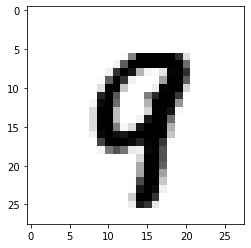

In [5]:
# example
display_image(X, 800)

#### Split Data

In [6]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(f"Training Data -> X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test Data -> X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data -> X_train: (46900, 784), y_train: (46900,)
Test Data -> X_test: (23100, 784), y_test: (23100,)


#### Scale Features

In [7]:
# scale features
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

#### PCA

In [8]:
# run and fit pca on scaled training data
pca = PCA()
pca.fit(X_train_norm)

# project original data on PCs
# note that we have not specified the no. of PCs, thus the
# data is being projected on n_initial (784) PCs
Z_train = pca.transform(X_train_norm)
Z_test = pca.transform(X_test_norm)

#### Train Models

In [9]:
# the amount of variances we want to retain
variances = [1.00, 0.95, 0.90, 0.85]

# variables to see how models trained with different variance retained compare
n_components = [] # number of principle components used
accuracies = [] # the accuracy of each model on test set
time_intervals = [] # the time it takes to fit the model

for var in variances:
    # find the no. of PCs n we need to reach this variance
    n = 0
    if var == 1.00: # in case var is 1.00, we'd simply use all the PCs
        n = n_initial
    else:
        # increase until we have enough PCs to retain this variance (var)
        while np.sum(pca.explained_variance_ratio_[:n]) < var:
            n += 1

    # record no. of PCs
    print(f"For {var} variance retained, we need {n} principle components.")
    n_components.append(n)
    
    # Reduce train and test matrices
    Z_train_red = Z_train[:, :n]
    Z_test_red = Z_test[:, :n]
    
    # train model on a Z (original data projected on n PCs)
    print(f'Training model using {n} components...')
    model = LogisticRegression(dual=False, max_iter=1000)
    start = time.time()
    model.fit(Z_train_red, y_train)
    stop = time.time()
    
    # record time
    time_taken = round(stop - start, 2)
    print(f"The time taken to train the model using {n} PCs is {time_taken}s.")
    time_intervals.append(time_taken) 
        
    # predict and calculate accuracy on test set
    y_pred = model.predict(Z_test_red)
    acc = round(sum(y_pred == y_test) / y_test.size * 100, 2)
    
    # record accuracy
    print(f"The accuracy for a model trained with {n} PCs is {acc}.")
    accuracies.append(acc)
    
    print("------------------------------------------------------")

For 1.0 variance retained, we need 784 principle components.
Training model using 784 components...
The time taken to train the model using 784 PCs is 138.58s.
The accuracy for a model trained with 784 PCs is 90.95.
------------------------------------------------------
For 0.95 variance retained, we need 322 principle components.
Training model using 322 components...
The time taken to train the model using 322 PCs is 73.54s.
The accuracy for a model trained with 322 PCs is 91.86.
------------------------------------------------------
For 0.9 variance retained, we need 229 principle components.
Training model using 229 components...
The time taken to train the model using 229 PCs is 60.56s.
The accuracy for a model trained with 229 PCs is 91.85.
------------------------------------------------------
For 0.85 variance retained, we need 178 principle components.
Training model using 178 components...
The time taken to train the model using 178 PCs is 56.29s.
The accuracy for a model tra

#### Plot How the Different Models Compare

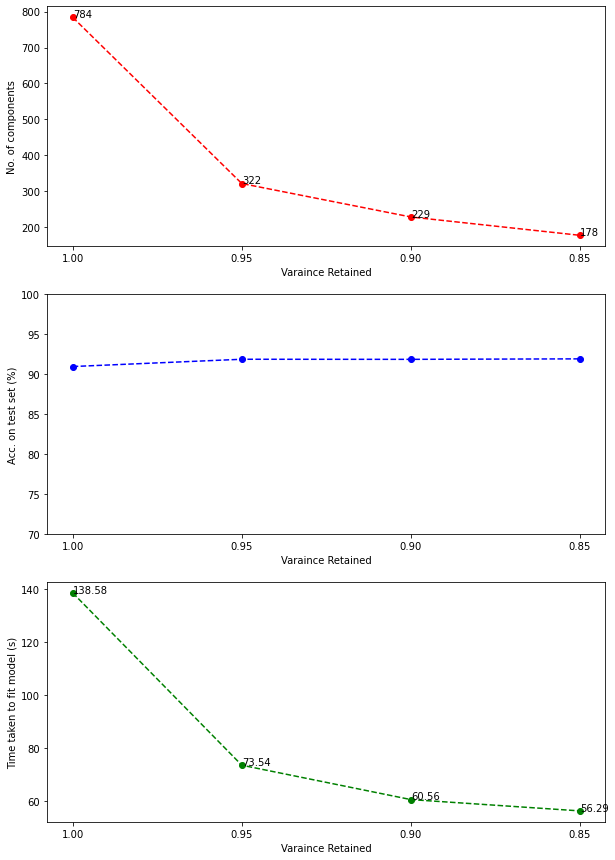

In [10]:
fig, axs = plt.subplots(3, figsize=(10, 15))

# plot variance-retained against no. of PCs
axs[0].plot(variances, n_components, '--ro')
axs[0].set(ylabel="No. of components")
for v, n in zip(variances, n_components):
    axs[0].annotate(n, xy=(v, n))

# plot variance-retained against model accuracy on test set
axs[1].plot(variances, accuracies, '--bo')
axs[1].set(ylabel="Acc. on test set (%)", ylim=(70, 100))

# plot variance-retained against time taken to train model
axs[2].plot(variances, time_intervals, '--go')
axs[2].set(ylabel="Time taken to fit model (s)")
for v, t in zip(variances, time_intervals):
    axs[2].annotate(t, xy=(v, t))

# some common settings for each subplot
for ax in axs:
    ax.set(xlabel='Varaince Retained', xticks=variances)
    ax.invert_xaxis()

pass

**Observations:**
   
We see that reducing the variance retained from 1.00 to 0.85, and as a result reducing the number of Principle Components from 784 to 178, to train our model barely affects the accuracy of our model to predict the test set while greatly lowers the time it takes to fit the model.

#### Bonus: Predict a Random Test Set Example

Model prediction: 9


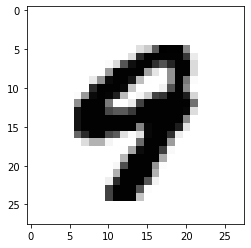

In [11]:
# run this cell to test your model on a random example from the test set
# using the last model we trained
idx = np.random.choice(y_test.size)

display_image(X_test, idx)
pred = model.predict(Z_test_red[idx, :].reshape((1, -1)))
print(f"Model prediction: {pred[0]}")